# Target Time And Trailing Stops

In [1]:
from pandas_datareader import data  
from datetime import datetime
import pandas_datareader as pdr
import pandas as pd
import mplfinance as mpf
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython import display
pd.options.mode.chained_assignment = None

## Nasdaq 100 Futures from mid 2019 to 2020

In [2]:
start = datetime(2019,6,1)
end = datetime(2019,12,1)
# NASDAQ FUTURES
df = pdr.get_data_yahoo('NQ=F', start ,end)

In [3]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-05-31,7256.00,7129.25,7251.75,7133.50,540433.0,7133.50
2019-06-03,7132.50,6941.25,7110.00,6993.75,771723.0,6993.75
2019-06-04,7186.50,6981.75,7008.75,7179.25,565396.0,7179.25
2019-06-05,7245.25,7150.25,7189.00,7228.50,534798.0,7228.50
2019-06-06,7299.25,7181.00,7213.75,7282.25,433916.0,7282.25
...,...,...,...,...,...,...
2019-11-21,8308.00,8240.00,8261.50,8274.50,411833.0,8274.50
2019-11-22,8313.50,8233.25,8280.25,8280.50,344497.0,8280.50
2019-11-25,8379.25,8296.50,8303.25,8376.50,259485.0,8376.50


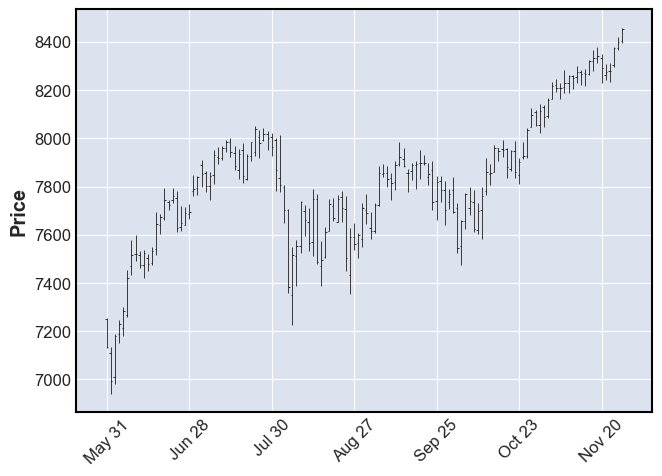

In [4]:
mpf.plot(df)

## Generate short-term, intermediate-term

In [5]:
# Remove inside days & outside days
clean_df = df.copy()
while True:
    clean_df['prev_low'] = clean_df['Low'].shift(1)
    clean_df['next_low'] = clean_df['Low'].shift(-1)
    clean_df['prev_high'] = clean_df['High'].shift(1)
    clean_df['next_high'] = clean_df['High'].shift(-1)
    # remove inside day
    inside_day = clean_df[(clean_df['prev_high'] >= clean_df['High']) & (clean_df['prev_low'] <= clean_df['Low'])].index
    clean_df = clean_df.loc[~clean_df.index.isin(inside_day[:1])]
    if len(inside_day) > 0:
        continue
    # remove outside day
    outside_day = clean_df[(clean_df['prev_high'] <= clean_df['High']) & (clean_df['prev_low'] >= clean_df['Low'])].index
    clean_df = clean_df.loc[~clean_df.index.isin(outside_day[:1])]
    if len(outside_day) > 0:
        continue
    break

# Find short term high, short term low points
df['short_term_high'] = np.NaN
df['short_term_low'] = np.NaN
df.loc[clean_df[(clean_df['High'] > clean_df['prev_high']) & (clean_df['High'] > clean_df['next_high'])].index, 'short_term_high'] = clean_df['High']
df.loc[clean_df[(clean_df['Low'] < clean_df['prev_low']) & (clean_df['Low'] < clean_df['next_low'])].index, 'short_term_low'] = clean_df['Low']
df['short_term'] = np.NaN
df['short_term'].loc[df['short_term_high'].dropna().index] = df['short_term_high']
df['short_term'].loc[df['short_term_low'].dropna().index] = df['short_term_low']
# for draw end line
df['short_term'].iloc[0] = df['Open'].iloc[0]
df['short_term'].iloc[-1] = df['Close'].iloc[-1]

# Find intermediate term high, intermediate term low points
inter_df = pd.DataFrame()
inter_df = df[['short_term_high']].dropna()
inter_df['prev_short_term_high'] = inter_df['short_term_high'].shift(1)
inter_df['next_short_term_high'] = inter_df['short_term_high'].shift(-1)
df['intermediate_term_high'] = np.NaN
df.loc[
    inter_df[
      (inter_df['prev_short_term_high'] < inter_df['short_term_high']) & 
      (inter_df['next_short_term_high'] < inter_df['short_term_high'])].index, 
       'intermediate_term_high'
    ] = clean_df['High']
inter_df = pd.DataFrame()
inter_df['short_term_low'] = df['short_term_low'].dropna()
inter_df['prev_short_term_low'] = inter_df['short_term_low'].shift(1)
inter_df['next_short_term_low'] = inter_df['short_term_low'].shift(-1)
df['intermediate_term_low'] = np.NaN
df.loc[
    inter_df[
      (inter_df['prev_short_term_low'] > inter_df['short_term_low']) & 
      (inter_df['next_short_term_low'] > inter_df['short_term_low'])].index, 
       'intermediate_term_low'
    ] = clean_df['Low']
df['intermediate_term'] = np.NaN
df['intermediate_term'].loc[df['intermediate_term_high'].dropna().index] = df['intermediate_term_high']
df['intermediate_term'].loc[df['intermediate_term_low'].dropna().index] = df['intermediate_term_low']
# for draw end line
df['intermediate_term'].loc[df['short_term'].dropna().index[0]] = df['short_term'].dropna().iloc[0]
df['intermediate_term'].loc[df['short_term'].dropna().index[-1]] = df['short_term'].dropna().iloc[-1]

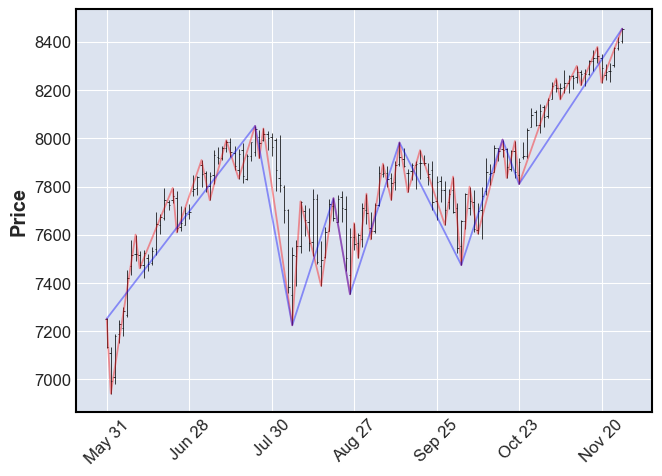

In [6]:
apds = [
    mpf.make_addplot(df['short_term'].interpolate(method='linear'), color='red', alpha=0.4),
    mpf.make_addplot(df['intermediate_term'].interpolate(method='linear'), color='blue', alpha=0.4)
]
mpf.plot(df, addplot=apds)

## Forming an intermediate-term low higher than the last intermediate-term low 

In [7]:
df['higher_intermediate_term_low'] = np.NAN
df['higher_intermediate_term_low'] = df.loc[df['intermediate_term_low'].ffill() > df['intermediate_term_low'].ffill().shift(1), 'intermediate_term_low']

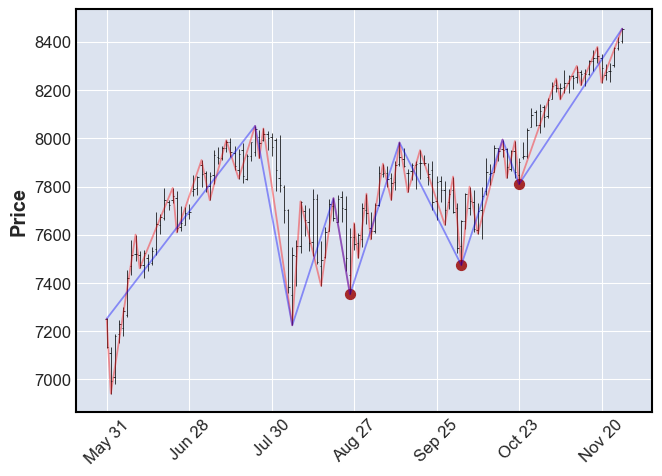

In [8]:
apds = [
    mpf.make_addplot(df['short_term'].interpolate(method='linear'), color='red', alpha=0.4),
    mpf.make_addplot(df['intermediate_term'].interpolate(method='linear'), color='blue', alpha=0.4),
    mpf.make_addplot(df['higher_intermediate_term_low'], color='brown', marker='o', scatter=True, markersize=50),
]
mpf.plot(df, addplot=apds)

## Higher short-term low we knew we had a higher intermediate-term low

In [9]:
temp = df['short_term_low'].dropna().index.isin(df['higher_intermediate_term_low'].dropna().index)
temp[-1] = False

In [10]:
df['intermediate_term_low_complete'] = np.NAN
df['intermediate_term_low_complete'] = df['short_term_low'].dropna().loc[np.roll(temp, 1)]

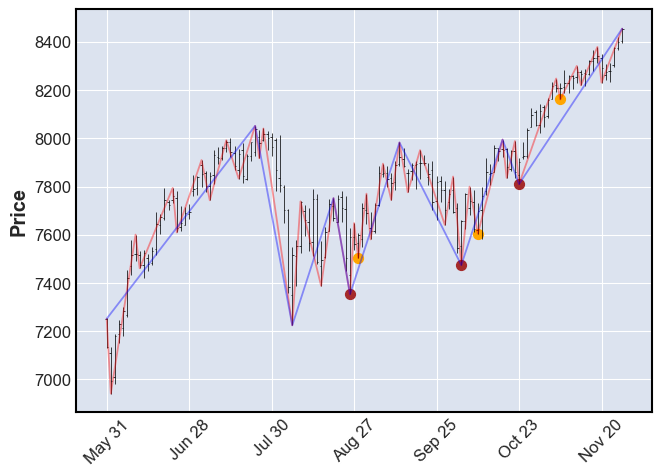

In [11]:
apds = [
    mpf.make_addplot(df['short_term'].interpolate(method='linear'), color='red', alpha=0.4),
    mpf.make_addplot(df['intermediate_term'].interpolate(method='linear'), color='blue', alpha=0.4),
    mpf.make_addplot(df['higher_intermediate_term_low'], color='brown', marker='o', scatter=True, markersize=50),
    mpf.make_addplot(df['intermediate_term_low_complete'], color='orange', marker='o', scatter=True, markersize=50),
]
mpf.plot(df, addplot=apds)

## Higher low we knew we had a higher short-term low (entry point)

In [12]:
temp = clean_df['Close'].dropna().index.isin(df['intermediate_term_low_complete'].dropna().index)
temp[-1] = False

In [13]:
df['short_term_low_complete'] = np.NAN
df['short_term_low_complete'] = clean_df['Close'].dropna().loc[np.roll(temp, 1)]

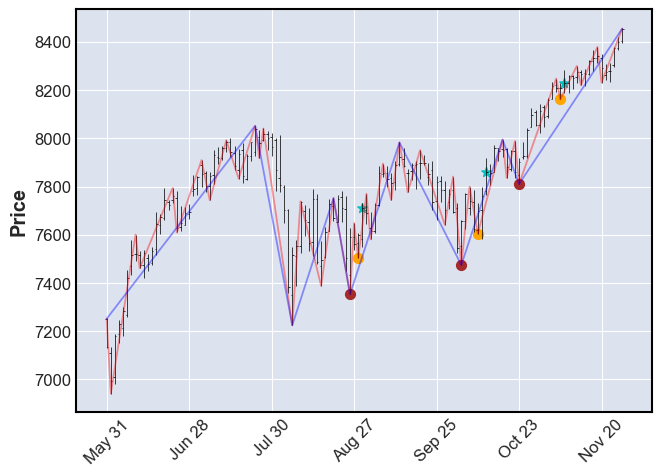

In [14]:
apds = [
    mpf.make_addplot(df['short_term'].interpolate(method='linear'), color='red', alpha=0.4),
    mpf.make_addplot(df['intermediate_term'].interpolate(method='linear'), color='blue', alpha=0.4),
    mpf.make_addplot(df['higher_intermediate_term_low'], color='brown', marker='o', scatter=True, markersize=50),
    mpf.make_addplot(df['intermediate_term_low_complete'], color='orange', marker='o', scatter=True, markersize=50),
    mpf.make_addplot(df['short_term_low_complete'], color='c', marker='*', scatter=True, markersize=50),
]
mpf.plot(df, addplot=apds)

## Intermediate-term target

In [15]:
temp = df.loc[df['intermediate_term'].dropna().index, ['intermediate_term','intermediate_term_high', 'higher_intermediate_term_low']]

In [16]:
df['intermediate_term_target'] = np.NaN
df['intermediate_term_target'] = (temp['intermediate_term_high'].ffill() - temp['higher_intermediate_term_low']) * 2 + temp['higher_intermediate_term_low']

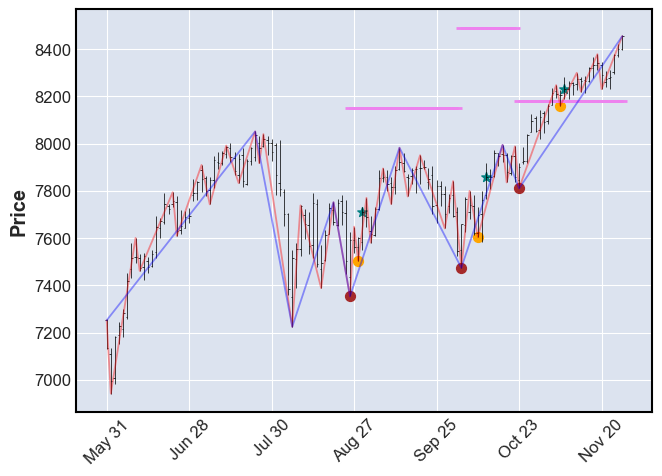

In [17]:
apds = [
    mpf.make_addplot(df['short_term'].interpolate(method='linear'), color='red', alpha=0.4),
    mpf.make_addplot(df['intermediate_term'].interpolate(method='linear'), color='blue', alpha=0.4),
    mpf.make_addplot(df['higher_intermediate_term_low'], color='brown', marker='o', scatter=True, markersize=50),
    mpf.make_addplot(df['intermediate_term_low_complete'], color='orange', marker='o', scatter=True, markersize=50),
    mpf.make_addplot(df['short_term_low_complete'], color='teal', marker='*', scatter=True, markersize=50),
    mpf.make_addplot(df['intermediate_term_target'].ffill(), color='violet', marker='_', scatter=True, markersize=50),
]
mpf.plot(df, addplot=apds)

## Trailing Stops

In [18]:
temp = df[df['short_term_low'].index >= df['higher_intermediate_term_low'].dropna().index[0]]

In [19]:
df['trailing_stop'] = np.NaN
df['trailing_stop'] = temp[temp['short_term_low'].ffill().shift(1) < temp['short_term_low']]['Low']

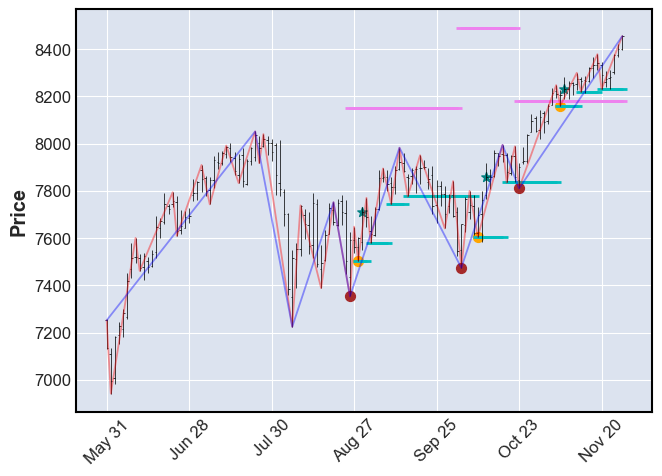

In [20]:
apds = [
    mpf.make_addplot(df['short_term'].interpolate(method='linear'), color='red', alpha=0.4),
    mpf.make_addplot(df['intermediate_term'].interpolate(method='linear'), color='blue', alpha=0.4),
    mpf.make_addplot(df['higher_intermediate_term_low'], color='brown', marker='o', scatter=True, markersize=50),
    mpf.make_addplot(df['intermediate_term_low_complete'], color='orange', marker='o', scatter=True, markersize=50),
    mpf.make_addplot(df['short_term_low_complete'], color='teal', marker='*', scatter=True, markersize=50),
    mpf.make_addplot(df['intermediate_term_target'].ffill(), color='violet', marker='_', scatter=True, markersize=50),
    mpf.make_addplot(df['trailing_stop'].ffill(), color='c', marker='_', scatter=True, markersize=50),
]
mpf.plot(df, addplot=apds)